In [76]:
using FileIO
using CSV
using DataFrames
using LinearAlgebra
using Statistics
using Glob
using Parameters

using Plots
using PGFPlots


In [78]:
pgfplots()

Plots.PGFPlotsBackend()

In [79]:
@with_kw mutable struct ScenarioResult 
    filename::String = "filename"
    algorithm::String = "algorithm"
    policy::String = "policy"
    collision_cost::Float64 = 0.
    probability_pedestrian_birth::Float64 = 0.
    action_lon_cost::Float64 = 0.
    action_lat_cost::Float64 = 0.
    keep_velocity_reward::Float64 = 0.
    keep_lane_reward::Float64 = 0.
    
    sum_scenarios::Int = 0
    sum_collisions::Int = 0
    sum_emergency_brake_interventions::Int = 0
    dv::Float64 = 0.
    v_mean::Float64 = 0.
    a_mean::Float64 = 0.
    a_jerk::Float64 = 0.
    a_min::Float64 = 0.
end


function evaluate_file(filename)
    
    result = ScenarioResult()
    result.filename = filename
    file_name_parameters = split(filename,'_')
    collision_cost = 0.
    probability_pedestrian_birth = 0.
    action_lon_cost = 0.
    action_lat_cost = 0.
    keep_velocity_reward = 0.
    if ( file_name_parameters[2] != "EmergencyBrakingSystem")    
        if ( file_name_parameters[3] == "EmergencyBrakingSystem")
            result.algorithm = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem" 
            result.policy = file_name_parameters[4]
            result.collision_cost = parse(Float64, file_name_parameters[5])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[6])
            result.action_lon_cost = parse(Float64, file_name_parameters[7])
            result.action_lat_cost = parse(Float64, file_name_parameters[8])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[9])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[10])
            catch
                
            end
        else
            result.algorithm = "PedestrianAvoidancePOMDP" 
            result.policy = file_name_parameters[3]
            result.collision_cost = parse(Float64, file_name_parameters[4])
            result.probability_pedestrian_birth = parse(Float64, file_name_parameters[5])
            result.action_lon_cost = parse(Float64, file_name_parameters[6])
            result.action_lat_cost = parse(Float64, file_name_parameters[7])
            result.keep_velocity_reward = parse(Float64, file_name_parameters[8])
            try
                result.keep_lane_reward = parse(Float64, file_name_parameters[9])
            catch
                
            end
        end
    else
        result.algorithm = "EmergencyBrakingSystem" 
    end

    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []

    for row in CSV.File(filename)
        push!(dv, row.dv_collision)
        push!(v_mean, row.v_mean)
        push!(a_mean, row.a_mean)
        push!(a_jerk, row.a_jerk)
        push!(a_min, row.a_min)
        result.sum_collisions += row.collision
        result.sum_emergency_brake_interventions += row.eb_intervention
        result.sum_scenarios += 1
    end

    result.dv = mean(dv)
    result.v_mean = mean(v_mean)
    result.a_mean = mean(a_mean)
    result.a_jerk = mean(a_jerk)
    result.a_min = mean(a_min)

    return result
end

evaluate_file (generic function with 1 method)

In [81]:
# get results from Emergency Braking System

files = glob("results_EmergencyBrakingSystem_*.csv")
results_ermergency_system = []
for file_name in files
    result = evaluate_file(file_name) 
    push!(results_ermergency_system, result)
    println(result)
end

ScenarioResult
  filename: String "results_EmergencyBrakingSystem_no.jld2.csv"
  algorithm: String "EmergencyBrakingSystem"
  policy: String "policy"
  collision_cost: Float64 0.0
  probability_pedestrian_birth: Float64 0.0
  action_lon_cost: Float64 0.0
  action_lat_cost: Float64 0.0
  keep_velocity_reward: Float64 0.0
  keep_lane_reward: Float64 0.0
  sum_scenarios: Int64 26
  sum_collisions: Int64 3
  sum_emergency_brake_interventions: Int64 24
  dv: Float64 1.1121794871794872
  v_mean: Float64 12.095090684754608
  a_mean: Float64 -8.655748098055792
  a_jerk: Float64 17.307692307692307
  a_min: Float64 -9.23076923076923



In [269]:
#folder_name = "PedestrianAvoidancePOMDP_EmergencyBrakingSystem_longitudinal2"
folder_name = "PedestrianAvoidancePOMDP_longitudinal2"


current_path = pwd()
try
    cd(folder_name)
    files = glob(string("results_", folder_name, "*.csv" ))
    results = []
    for file_name in files
        result = evaluate_file(file_name) 
        push!(results, result)
    end
    
catch
end

cd(current_path)

length(results)

80

In [270]:
# evaluation based on actionloncost and keepvelocityreward

probability_pedestrian_birth = 0.2

actionloncost = [0., -1., -2., -5.]
keepvelocityreward = [0., 10., 20., 30., 40.]

plots_vmean = PGFPlots.Axis[]
plots_collision = PGFPlots.Axis[] 

cnt = 0
probability_pedestrian_births = [0.2 0.3 0.4 0.5] 
for probability_pedestrian_birth in probability_pedestrian_births
    println("ped-p: ", probability_pedestrian_birth)
    cnt = cnt + 1
    
    # find relevant configurations
    id_matrix = zeros(Int64, length(actionloncost), length(keepvelocityreward))
    for i=1:length(results)
        result = results[i]
        if result.probability_pedestrian_birth == probability_pedestrian_birth
            id_action_lon_cost = findall(x->x == result.action_lon_cost, actionloncost)
            id_keep_velocity_reward = findall(x->x == result.keep_velocity_reward, keepvelocityreward )
            id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
        end
    end
    println(id_matrix)

    plot_vmean = PGFPlots.Axis(style="width=8cm, height=5cm, grid=both", legendPos="south west", 
        ymin=15, ymax=40, xmin=minimum(actionloncost), xmax=maximum(actionloncost), title=string("Probability pedestrian apperance: ", probability_pedestrian_birth), 
        xlabel="Penalty longitudinal action [-]", ylabel=L"$v_{EGO\_MEAN}{[}km/h{]}$")


    y_label = "Collisions"
    if ( occursin("EmergencyBrakingSystem", results[1].algorithm) )
        y_label = "Collisions / ES Interventions"
    end

    plot_collision = PGFPlots.Axis(style="width=8cm, height=5cm, grid=both", legendPos="south west", 
        ymin=0, ymax=10, xmin=minimum(actionloncost), xmax=maximum(actionloncost), #=title=string("Probability pedestrian apperance: ", probability_pedestrian_birth), =# 
        xlabel="Penalty longitudinal action [-]", ylabel=y_label)


    for i = 1:length(keepvelocityreward)
        println(" ")
        println("---- keepvelocityreward: ", keepvelocityreward[i])
        sum_collisions = Float64[]
        sum_emergency_brake_interventions = Float64[]
        dv = []
        v_mean = []
        a_mean = []
        a_jerk = []
        a_min = []
        for id in id_matrix[:,i]
            #println(id)
            push!(sum_collisions, results[id].sum_collisions)
            push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
            push!(dv, results[id].dv)  
            push!(v_mean, results[id].v_mean)
            push!(a_mean, results[id].a_mean)
            push!(a_jerk, results[id].a_jerk)
            push!(a_min, results[id].a_min)
            if ( results[id].v_mean > 8.5 && results[id].sum_collisions == 0 && results[id].sum_emergency_brake_interventions <= 5)
               # println(id)
               # println(results[id])
            end
            #println(results[id].a_jerk)

        end
        println("velocity reward: ", keepvelocityreward[i])
        println("collisions: ", sum_collisions)
        println("sum_emergency_brake_interventions: ", sum_emergency_brake_interventions)
        println("v_mean: ", v_mean)

      #  plot!(actionloncost, sum_collisions, label=string("sum collisions velocity-reward:", keepvelocityreward[i]))#, lab=[string("collisions velocity-reward:", keepvelocityreward[i])])# )
      #  plot!(actionloncost, sum_emergency_brake_interventions, label="#brake_interventions" )
      #  plot!(actionloncost, a_mean, label="a_mean" )
       # plot!(actionloncost, a_jerk, label="a_jerk" )

        p_v = PGFPlots.Linear(actionloncost, v_mean*3.6, legendentry=string("Velocity reward: ", keepvelocityreward[i]))
        push!(plot_vmean, p_v)
        
        p_collision = PGFPlots.Linear(actionloncost, sum_collisions, style="red", legendentry=string("Collisions / Velocity reward: ", keepvelocityreward[i]))
        push!(plot_collision, p_collision)

        if ( occursin("EmergencyBrakingSystem", results[1].algorithm) )
            p_es_interventions = PGFPlots.Linear(actionloncost, sum_emergency_brake_interventions, style="blue", legendentry=string("ES Interventions / Velocity reward: ", keepvelocityreward[i]))
            push!(plot_collision, p_es_interventions)
        end
        

        
        if ( cnt == length(probability_pedestrian_births) )
            plot_vmean.legendStyle = "{at={(1.1, 0.0)}}"
            plot_collision.legendStyle = "{at={(1.1, -0.2)}}"
        else
            push!(plot_vmean, PGFPlots.Command("\\legend{}"))
            push!(plot_collision, PGFPlots.Command("\\legend{}"))            
        end
    end

    push!(plots_vmean, plot_vmean)
    push!(plots_collision, plot_collision)
    
end  


ped-p: 0.2
[16 17 18 19 20; 1 2 3 4 5; 6 7 8 9 10; 11 12 13 14 15]
 
---- keepvelocityreward: 0.0
velocity reward: 0.0
collisions: [1.0, 0.0, 0.0, 7.0]
sum_emergency_brake_interventions: [0.0, 0.0, 0.0, 0.0]
v_mean: Any[5.36226, 7.20714, 8.63055, 10.0335]
 
---- keepvelocityreward: 10.0
velocity reward: 10.0
collisions: [3.0, 2.0, 5.0, 7.0]
sum_emergency_brake_interventions: [0.0, 0.0, 0.0, 0.0]
v_mean: Any[8.2286, 8.17905, 9.30018, 9.77398]
 
---- keepvelocityreward: 20.0
velocity reward: 20.0
collisions: [5.0, 4.0, 6.0, 7.0]
sum_emergency_brake_interventions: [0.0, 0.0, 0.0, 0.0]
v_mean: Any[8.51777, 8.70712, 9.46628, 9.71723]
 
---- keepvelocityreward: 30.0
velocity reward: 30.0
collisions: [6.0, 6.0, 7.0, 7.0]
sum_emergency_brake_interventions: [0.0, 0.0, 0.0, 0.0]
v_mean: Any[9.26694, 9.38087, 9.60248, 9.7485]
 
---- keepvelocityreward: 40.0
velocity reward: 40.0
collisions: [6.0, 6.0, 7.0, 8.0]
sum_emergency_brake_interventions: [0.0, 0.0, 0.0, 0.0]
v_mean: Any[9.27186, 9.26359, 

┌ Warning: performance_reward_PedestrianAvoidancePOMDP_longitudinal2.pdf already exists, overwriting!
└ @ TikzPictures /home/xubuntu/.julia/packages/TikzPictures/b9irC/src/TikzPictures.jl:253


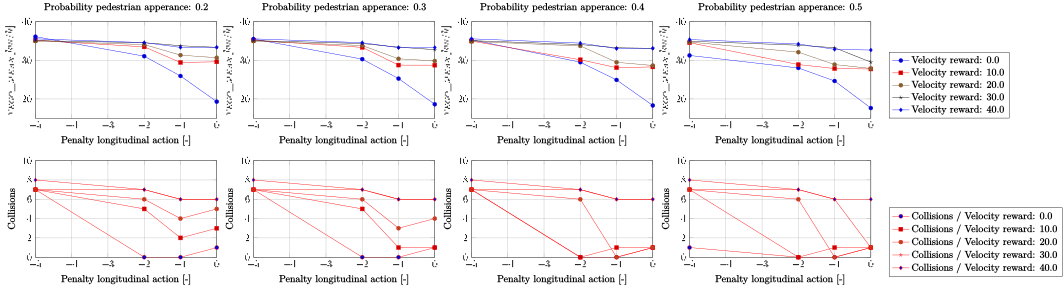

In [271]:

plot_reward = GroupPlot(length(plots_collision), 2, groupStyle = "horizontal sep = 1.3cm, vertical sep = 1.5cm")

for plot_vmean in plots_vmean
    push!(plot_reward, plot_vmean)
end

for plot_collision in plots_collision
    push!(plot_reward, plot_collision)
end


PGFPlots.save(string("performance_reward_", folder_name, ".pdf"), plot_reward)
plot_reward


In [ ]:

plot()

for i = 1:length(actionloncost)
    #println(i)
    sum_collisions = []
    sum_emergency_brake_interventions = []
    dv = []
    v_mean = []
    a_mean = []
    a_jerk = []
    a_min = []
    for id in id_matrix[i,:]
        #println(id)
        #println(results[id])
        push!(sum_collisions, results[id].sum_collisions)
        push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
        push!(dv, results[id].dv)  
        push!(v_mean, results[id].v_mean)
        push!(a_mean, results[id].a_mean)
        push!(a_jerk, results[id].a_jerk)
        push!(a_min, results[id].a_min)
    end
    println(keepvelocityreward)
    println(v_mean)
    println(sum_collisions)

    println("----")
    plot!(keepvelocityreward, sum_collisions, label="#collisions" )
   # plot!(keepvelocityreward, sum_emergency_brake_interventions, label="#brake_interventions" )
   # plot!(keepvelocityreward, a_mean, label="a_mean" )
   # plot!(keepvelocityreward, a_jerk, label="a_jerk" )
   # plot!(keepvelocityreward, v_mean, label="v_mean" )
end

plot!()

In [ ]:
using Plots
pgfplots()



actionloncost = [0., -1., -2., -5.]
keepvelocityreward = [0., 10., 20., 30., 40.]
p_birth_ped = [0.1, 0.2, 0.3]

re = [];

p = plot()

for p_birth in p_birth_ped
    id_matrix = zeros(Int64, length(actionloncost), length(keepvelocityreward))
    for i=1:length(results)
        result = results[i]
        if result.probability_pedestrian_birth == p_birth
            id_action_lon_cost = findall(x->x == result.action_lon_cost, actionloncost)
            id_keep_velocity_reward = findall(x->x == result.keep_velocity_reward, keepvelocityreward )
            id_matrix[id_action_lon_cost[1],id_keep_velocity_reward[1]] = i 
        end
    end
    println(id_matrix)

    for i = 1:length(keepvelocityreward)
        sum_collisions = []
        sum_emergency_brake_interventions = []
        dv = []
        v_mean = []
        a_mean = []
        a_jerk = []
        a_min = []
        for id in id_matrix[:,i]
            #println(id)
            push!(sum_collisions, results[id].sum_collisions)
            push!(sum_emergency_brake_interventions, results[id].sum_emergency_brake_interventions)
            push!(dv, results[id].dv)  
            push!(v_mean, results[id].v_mean)
            push!(a_mean, results[id].a_mean)
            push!(a_jerk, results[id].a_jerk)
            push!(a_min, results[id].a_min)
            push!(re, [results[id].sum_collisions, results[id].sum_emergency_brake_interventions, results[id].v_mean])
           #plot!(results[id].v_mean, results[id].sum_emergency_brake_interventions )
           plot!(results[id].v_mean:results[id].v_mean, results[id].sum_collisions:results[id].sum_collisions,  marker = ( 5, 0.6, :green, stroke(3, 0.2, :black, :dot)) )
        end

    end
    
end


plot!()

In [ ]:
verts = [(-1.0, 1.0), (-1.28, 0.6), (-0.2, -1.4), (0.2, -1.4), (1.28, 0.6), (1.0, 1.0), (-1.0, 1.0), (-0.2, -0.6), (0.0, -0.2), (-0.4, 0.6), (1.28, 0.6), (0.2, -1.4), (-0.2, -1.4), (0.6, 0.2), (-0.2, 0.2), (0.0, -0.2), (0.2, 0.2), (-0.2, -0.6)]
x = 0.1:0.2:0.9
y = 0.7 * rand(5) .+ 0.15
plot(x, y, line=(3, :dash, :lightblue), marker=(Shape(verts), 30, RGBA(0, 0, 0, 0.2)), xlim=(0, 1), ylim=(0, 1), leg=false)


In [ ]:
linetypes = [:path :steppre :steppost :sticks :scatter]
n = 2
x = Vector[sort(rand(20)) for i = 1:n]
y = rand(20, n)
plot(x, y, line=(linetypes, 3), lab=["test", string("test", 2)], ms=15)

In [ ]:
p1

In [ ]:
p2 = deepcopy(p1)
p3 = deepcopy(p1)
p4 = deepcopy(p1)

plot(p1,p2,p3,p4, layout=(2,2))

In [ ]:
x = 1:10; y = rand(10,2) # 2 columns means two lines
p1 = plot(x,y) # Make a line plot
p2 = scatter(x,y) # Make a scatter plot
p3 = plot(x,y,xlabel="This one is labelled",lw=3,title="Subtitle")
p4 = histogram(x,y) # Four histograms each with 10 points? Why not!
plot(p1,p2,p3,p4,layout=(2,2),legend=false)